The goal of this notebook is to **use Google's GTFS data to find out how many trains are operating in the NYC Subway at any given time**. Along the way, we will also how frequency changes throughout the train schedule and examine how frequency interacts with ridership numbers.

[MTA Developer Tools](https://new.mta.info/developers). The google data for the mta should be all that we need. There's weekday, saturday, and sunday service so only need to worry about those times. Additionally, there's data on the buses, LIRR and Metro North in there, too.
- [mta metrics dashboard](https://metrics.mta.info/?subway/customerjourneytimeperformance)

[time frequency](https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_services#Train_frequency_charts) breakdown

Some notes about the results:
- the routes change by day of week (for example the M not running its whole route on the weekends)
- some routes include service changes (the 7 and 7 express both count as the 7)
- this also includes late nights where the routes can change dramatically (e.g.: the 5 train doesn't leave the BX at night)
- two routes don't run on the weekends: the B and W

# Imports

In [89]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings(action='ignore')
import folium
import matplotlib.pyplot as plt
import imageio
from PIL import Image

## Functions

In [90]:
def x_minute_subway(station_df:pd.DataFrame, minutes:int):
    max_distance_meters = 80 * minutes
    meters_to_station_in_x_minutes = []
    for item in station_df['tph']:
        result = max_distance_meters - ((60 / item) * 80)
        if result < 0:
            result = 0
        meters_to_station_in_x_minutes.append(result)
    return meters_to_station_in_x_minutes

# Schedule Data

In [91]:
# holdays and other days when the data would be different than expected
calendar_dates_df = pd.read_csv("data/google_transit/calendar_dates.txt") 
calendar_df = pd.read_csv("data/google_transit/calendar.txt")
routes_df = pd.read_csv("data/google_transit/routes.txt")
stop_times_df = pd.read_csv("data/google_transit/stop_times.txt")
stops_df = pd.read_csv("data/google_transit/stops.txt")
transfers_df = pd.read_csv("data/google_transit/transfers.txt")

## Frequency Data 
(that I made)

In [92]:
first_stop_in_trip = pd.read_csv("saved_data/first_stop_in_trip.csv", index_col=0)
hourly_route_trip_freq = pd.read_csv("saved_data/hourly_route_trip_freq.csv", index_col=0)
frequency_by_stop_interval = pd.read_csv("saved_data/frequency_by_stop_interval.csv", index_col=0)
route_frequency_by_day = pd.read_csv("saved_data/route_frequency_by_day.csv", index_col=0)
daily_route_trip_freq = pd.read_csv("saved_data/daily_route_trip_freq.csv", index_col=0)
trip_interval_route_freq = pd.read_csv("saved_data/trip_interval_route_freq.csv", index_col=0)

In [93]:
train_area_df = pd.read_csv("saved_data/length_of_each_train.csv", index_col=0)
hourly_station_ridership = pd.read_csv("saved_data/hourly_station_ridership.csv", index_col=0)
station_complex_full_info = pd.read_csv("saved_data/station_complex_full_info.csv", index_col=0)

In [94]:
# Adding features to the station data 
# adding the rank of the station in terms of trains per hour on a 1-10 scale
station_complex_full_info['TPH_percent_rank'] = station_complex_full_info['tph'].rank(pct=True)
station_complex_full_info['Ridership_percent_rank'] = station_complex_full_info['avg_hourly_ridership'].rank(pct=True)
station_complex_full_info['Crowdedness_percent_rank'] = station_complex_full_info['hourly_ridership_per_train_direction'].rank(pct=True)
station_complex_full_info['distance_in_15'] = x_minute_subway(station_complex_full_info, 15)
station_complex_full_info['distance_in_30'] = x_minute_subway(station_complex_full_info, 30)
station_complex_full_info = station_complex_full_info.round(2)

In [95]:
# sorting the trip interval data by service
# sorting train_time_interval by time of day
time_of_day_sorting = {'Late Night': 0, 'Rush Hour AM': 1, 'Midday': 2
                                     , 'Rush Hour PM': 3, 'Evening': 4, 'Weekend': 5}
trip_interval_route_freq = trip_interval_route_freq.sort_values(by= ['route_id', 'train_time_interval']
                                    , key=lambda x: x.map(time_of_day_sorting)).reset_index(drop=True)

## Removing SIR 

In [96]:
daily_route_trip_freq = daily_route_trip_freq[daily_route_trip_freq['route_id']!='SI']
hourly_route_trip_freq = hourly_route_trip_freq[hourly_route_trip_freq['route_id']!='SI']

# Number of Train (sets) Running Per Day 

## Daily

In [97]:
# services with the most trains running overall
daily_route_trip_freq[['route_id', "Avg_num_trains_running"]].sort_values(by='Avg_num_trains_running'
                                                                          , ascending=False)[0:5]

,route_id,Avg_num_trains_running
12,F,21.4
1,2,20.4
7,A,19.7
5,6,19.5
20,N,19.1


In [98]:
# 288 trains running on average!
# this is trains moving at any one moment (Grand Central Shuttle counts as 1/4 of a train)
daily_route_trip_freq['Avg_num_trains_running'].sum()

283.4

## Train Time Interval

In [99]:
trip_interval_route_freq[['route_id', 'train_time_interval', 'Avg_num_trains_running']].sort_values(
                                                    by='Avg_num_trains_running', ascending=False)[0:5]

,route_id,train_time_interval,Avg_num_trains_running
36,F,Rush Hour AM,34.6
92,N,Rush Hour PM,32.6
44,N,Rush Hour AM,32.6
29,6,Rush Hour AM,32.5
84,F,Rush Hour PM,32.2


In [100]:
interval_number_of_trains_dict = {}
for value in frequency_by_stop_interval['train_time_interval'].unique():
    interval_avg_num_trains = trip_interval_route_freq[trip_interval_route_freq['train_time_interval']==value
                                                                                ]['Avg_num_trains_running'].sum()
    interval_number_of_trains_dict[value] = round(interval_avg_num_trains, 1)
train_time_interval_df = pd.DataFrame.from_dict(interval_number_of_trains_dict, orient='index'
                                                , columns=['Avg_number_of_trains_in_interval'])

In [101]:
train_time_interval_df.sort_values(by='Avg_number_of_trains_in_interval')

,Avg_number_of_trains_in_interval
Late Night,125.3
Weekend,223.3
Evening,239.5
Midday,353.2
Rush Hour PM,419.5
Rush Hour AM,443.1


In [102]:
# which routes has the most service per train time interval
# are there ties for the frequency??
trip_interval_route_freq[trip_interval_route_freq['headway_minutes'] < 1000].sort_values(
    by='Avg_num_trains_running').drop_duplicates(subset='train_time_interval', keep='last')

,route_id,train_time_interval,trains_per_hour,headway_seconds,headway_minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
7,A,Late Night,6,600.0,10.0,4850,80.8,16.2
121,2,Weekend,6,600.0,10.0,5744,95.7,19.1
108,F,Evening,9,400.0,6.7,4148,69.1,20.7
68,N,Midday,13,277.0,4.6,4186,69.8,30.2
92,N,Rush Hour PM,14,257.0,4.3,4186,69.8,32.6
36,F,Rush Hour AM,15,240.0,4.0,4148,69.1,34.6


### Plotting the Change in Frequency by Train Time Interval

In [135]:
trip_interval_route_freq.columns = ['route_id', 'Train Time Interval', 'trains_per_hour'
                                   , 'headway_seconds', 'Headway Minutes', 'route_time_seconds'
                                   , 'route_time_minutes', 'Avg_num_trains_running']

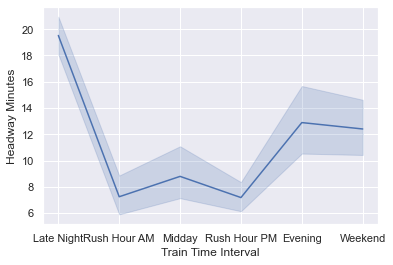

In [146]:
interval_headways_by_line = sns.lineplot(data=trip_interval_route_freq, x='Train Time Interval'
                                       , y='Headway Minutes')
fig = interval_headways_by_line.get_figure()
fig.savefig("saved_data/interval_headways.png") 

## Hourly

In [103]:
hourly_route_trip_freq['day_hour'] = [hourly_route_trip_freq['day_of_week'][idx] + "_" \
                                        + str(hourly_route_trip_freq['departure_hour'][idx])
                                            for idx in range(hourly_route_trip_freq.shape[0])]

In [104]:
hourly_route_trip_freq[['route_id', 'day_hour', 'Avg_num_trains_running']].sort_values(
                                                    by='Avg_num_trains_running', ascending=False)[0:5]

,route_id,day_hour,Avg_num_trains_running
845,F,Weekday_7,39.2
415,6,Weekday_7,38.3
127,2,Weekday_7,38.3
568,A,Weekday_16,37.7
1415,N,Weekday_16,37.2


In [105]:
hourly_number_of_trains_dict = {}
for value in hourly_route_trip_freq['day_hour'].unique():
    hourly_avg_num_trains = hourly_route_trip_freq[hourly_route_trip_freq['day_hour']==value
                                                                                ]['Avg_num_trains_running'].sum()
    hourly_number_of_trains_dict[value] = round(hourly_avg_num_trains, 1)
train_time_hourly_df = pd.DataFrame.from_dict(hourly_number_of_trains_dict, orient='index'
                                                , columns=['Avg_number_of_trains_in_hour'])

### Most frequent number of trains running

In [106]:
train_time_hourly_df[train_time_hourly_df['Avg_number_of_trains_in_hour']==
                     train_time_hourly_df['Avg_number_of_trains_in_hour'].max()]

,Avg_number_of_trains_in_hour
Weekday_16,489.7


In [107]:
# least frequent hours to use the subway
train_time_hourly_df.sort_values(by='Avg_number_of_trains_in_hour', ascending=False)[0:10]

,Avg_number_of_trains_in_hour
Weekday_16,489.7
Weekday_7,476.9
Weekday_8,467.2
Weekday_17,426.7
Weekday_15,409.2
Weekday_18,408.0
Weekday_6,403.0
Weekday_9,389.4
Weekday_19,389.1
Weekday_13,369.4


### Least frequent number of trains running

In [108]:
# least frequent hours to use the subway
train_time_hourly_df.sort_values(by='Avg_number_of_trains_in_hour')[0:10]

,Avg_number_of_trains_in_hour
Saturday_2,119.0
Saturday_3,119.0
Sunday_2,119.0
Weekday_3,119.0
Weekday_2,119.0
Sunday_3,119.0
Sunday_4,119.0
Weekday_0,119.6
Weekday_1,120.3
Saturday_1,120.3


In [109]:
train_time_hourly_df[train_time_hourly_df['Avg_number_of_trains_in_hour']==
                     train_time_hourly_df['Avg_number_of_trains_in_hour'].min()]

,Avg_number_of_trains_in_hour
Saturday_2,119.0
Saturday_3,119.0
Sunday_2,119.0
Sunday_3,119.0
Sunday_4,119.0
Weekday_2,119.0
Weekday_3,119.0


### Plotting number of trains runnings by Hour 

In [110]:
train_time_hourly_df_day = [x.split("_")[0] for x in train_time_hourly_df.index.values]
train_time_hourly_df_hour = [x.split("_")[1] for x in train_time_hourly_df.index.values]
train_time_hourly_df.columns = ['Avg Number of Trains in an Hour']
train_time_hourly_df['Day'] = train_time_hourly_df_day
train_time_hourly_df['Hour'] = train_time_hourly_df_hour

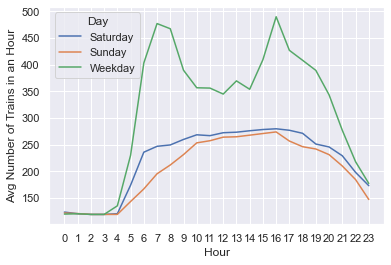

In [126]:
hourly_number_of_trains_by_day = sns.lineplot(data=train_time_hourly_df, x='Hour'
                                       , y='Avg Number of Trains in an Hour', hue='Day')
fig = hourly_number_of_trains_by_day.get_figure()
fig.savefig("saved_data/hourly_number_of_trains_by_day.png") 

In [123]:
ax

<AxesSubplot:xlabel='route_id', ylabel='headway_minutes'>

In [118]:
round(train_time_hourly_df.describe())

,Avg Number of Trains in an Hour
count,72.0
mean,246.0
std,98.0
min,119.0
25%,171.0
50%,248.0
75%,277.0
max,490.0


# Data Visualizations

In [27]:
sorted_routes = route_frequency_by_day[route_frequency_by_day
                                 ['day_of_week']=='Weekday'].sort_values(by='trains_per_hour')['route_id'].values


## Daily Average Frequency

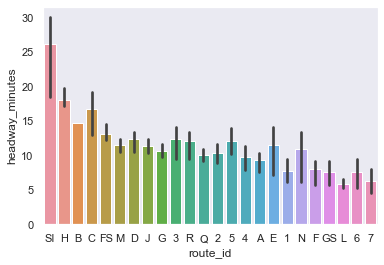

In [28]:
# with error bar 
ax = sns.barplot(data = route_frequency_by_day, x = 'route_id', y='headway_minutes'
                 , order=sorted_routes)
#     ax.title(interval)
ax.grid(axis='y')
plt.show()

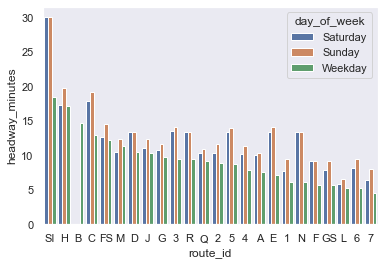

In [29]:
# separated by day 
ax = sns.barplot(data = route_frequency_by_day, x = 'route_id', y='headway_minutes'
                 , hue='day_of_week', order=sorted_routes)
#     ax.title(interval)
ax.grid(axis='y')
plt.show()

## Frequency by Interval

In [30]:
time_of_day_sorting

{'Late Night': 0,
 'Rush Hour AM': 1,
 'Midday': 2,
 'Rush Hour PM': 3,
 'Evening': 4,
 'Weekend': 5}

In [31]:
frequency_by_stop_interval

,parent_stop_id,train_time_interval,trains_per_hour
0,101,Evening,20
1,101,Late Night,7
2,101,Midday,22
3,101,Rush Hour AM,16
4,101,Rush Hour PM,25
...,...,...,...
2970,S31,Late Night,4
2971,S31,Midday,4
2972,S31,Rush Hour AM,11
2973,S31,Rush Hour PM,10


Late Night


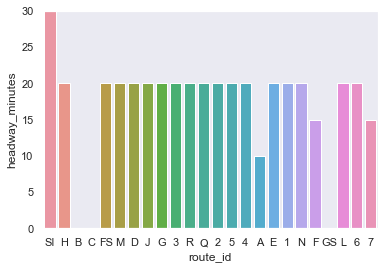

Rush Hour AM


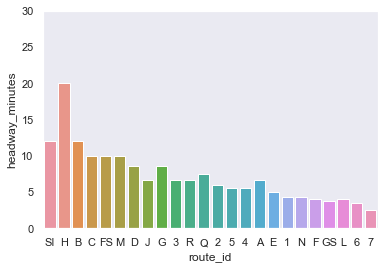

Midday


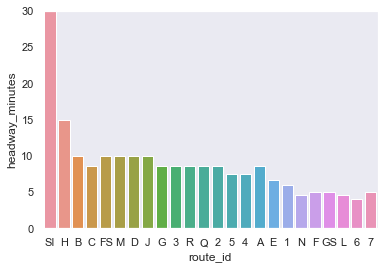

Rush Hour PM


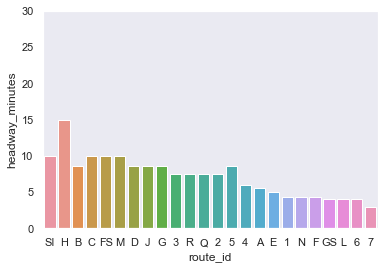

Evening


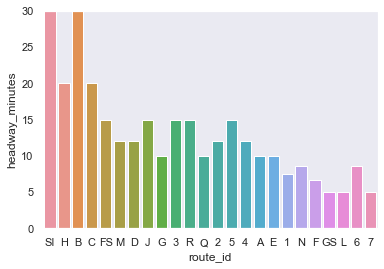

Weekend


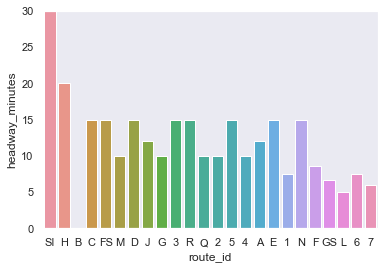

In [32]:
for interval in time_of_day_sorting.keys():
    print(interval)
    ax = sns.barplot(data=trip_interval_route_freq[trip_interval_route_freq
                                    ['train_time_interval']==interval]
                                 , x = 'route_id', y='headway_minutes', order=sorted_routes)
#     ax.title(interval)
    ax.grid(axis='y')
    ax.set_ylim(ymin=0, ymax=30)
    plt.show()

### Best and Worst Performers by Time of Day

In [33]:
# lowest  -- removing inf values first
# it's a tie for worst so let's just make it SIR lol 
trip_interval_route_freq[trip_interval_route_freq['headway_minutes'] < 1000].sort_values(
    by='headway_minutes').drop_duplicates(subset='train_time_interval', keep='last')

,route_id,train_time_interval,trains_per_hour,headway_seconds,headway_minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
88,H,Rush Hour PM,4,900.0,15.0,602,10.0,1.3
40,H,Rush Hour AM,3,1200.0,20.0,602,10.0,1.0
71,SI,Midday,2,1800.0,30.0,2418,40.3,2.7
104,B,Evening,2,1800.0,30.0,4303,71.7,4.8
23,SI,Late Night,2,1800.0,30.0,2418,40.3,2.7
142,SI,Weekend,2,1800.0,30.0,2418,40.3,2.7


In [34]:
trip_interval_route_freq[trip_interval_route_freq['headway_minutes'] < 1000].sort_values(
    by='headway_minutes', ascending=False).drop_duplicates(subset='train_time_interval', keep='last')

,route_id,train_time_interval,trains_per_hour,headway_seconds,headway_minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
7,A,Late Night,6,600.0,10.0,4850,80.8,16.2
137,L,Weekend,12,300.0,5.0,2235,37.2,14.9
102,7,Evening,12,300.0,5.0,2245,37.4,15.0
53,6,Midday,15,240.0,4.0,3445,57.4,28.7
78,7,Rush Hour PM,20,180.0,3.0,2245,37.4,24.9
30,7,Rush Hour AM,24,150.0,2.5,2245,37.4,29.9


### Ratios between train_time_intervals for each route

In [35]:
# maybe start with best to worst?

## Visualizing Hourly Frequency within a Service

In [36]:
# plot the headway minutes for a single line
l_train_hourly_df = hourly_route_trip_freq[hourly_route_trip_freq['route_id']=='L']

In [37]:
l_train_hourly_df_trimmed = l_train_hourly_df[['day_of_week', 'departure_hour', 'headway_seconds'
                                               , 'headway_minutes', 'Avg_num_trains_running', 'day_hour']]

In [38]:
l_train_hourly_df_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 1207 to 1278
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day_of_week             72 non-null     object 
 1   departure_hour          72 non-null     int64  
 2   headway_seconds         72 non-null     float64
 3   headway_minutes         72 non-null     float64
 4   Avg_num_trains_running  72 non-null     float64
 5   day_hour                72 non-null     object 
dtypes: float64(3), int64(1), object(2)
memory usage: 3.9+ KB


<AxesSubplot:xlabel='departure_hour', ylabel='headway_minutes'>

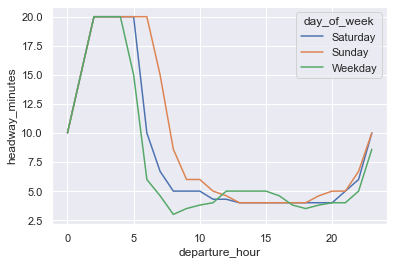

In [39]:
sns.lineplot(data=l_train_hourly_df_trimmed, x='departure_hour', y='headway_minutes', hue='day_of_week')

# How many route variations are there?
i.e.: how many different start stations and final stations are there on the schedule? e.g.: the 5 starting at E180 and ending at Eastchester/Dyre Ave is 1

In [40]:
# find the unique trip ids first and last stop_ids
# then find the unique combinations of those two stop_ids
min_stop_ids_idx = stop_times_df.groupby('trip_id')['stop_sequence'].idxmin()
max_stop_ids_idx = stop_times_df.groupby('trip_id')['stop_sequence'].idxmax()
min_stop_rows = stop_times_df.loc[min_stop_ids_idx].drop(columns=['arrival_time', 'departure_time'])
max_stop_rows = stop_times_df.loc[max_stop_ids_idx].drop(columns=['arrival_time', 'departure_time'])

In [41]:
trips_w_stops = pd.merge(min_stop_rows, max_stop_rows, on='trip_id')
trips_w_stops['start_stop'] = [str(trips_w_stops['stop_id_x'].iloc[idx]) + "_" + 
                               str(trips_w_stops['stop_id_y'].iloc[idx])
                               for idx in range(len(trips_w_stops))]
trips_w_stops['route_id'] = [x.split("_")[-1].split('.')[0] 
                                        for x in trips_w_stops['trip_id']]

In [42]:
all_start_and_stops_w_freq = trips_w_stops.start_stop.value_counts()

In [43]:
# 44 are run less than 5 times in a week 
# the average route is done 140 times in a week 
len(all_start_and_stops_w_freq[all_start_and_stops_w_freq.values < 5])
all_start_and_stops_w_freq.describe()

count    145.000000
mean     140.448276
std      186.497168
min        1.000000
25%        4.000000
50%       42.000000
75%      241.000000
max      735.000000
Name: start_stop, dtype: float64

In [44]:
trips_w_a_unique_start_stop = trips_w_stops.groupby('start_stop')['route_id'].max()

In [45]:
# which services have the most variations? (note, I'm counting permutations, not combinations)
# i don't understand why some services have an odd number of services
unique_service_patterns_by_service = trips_w_a_unique_start_stop.value_counts()
unique_service_patterns_by_service.head(5)

5    22
A    17
4    10
F     9
R     9
Name: route_id, dtype: int64

In [46]:
# looking at particular services 
trips_w_a_unique_start_stop[trips_w_a_unique_start_stop.values=='L']

start_stop
L01S_L17S    L
L01S_L29S    L
L17N_L01N    L
L28N_L01N    L
L29N_L01N    L
Name: route_id, dtype: object

# Max and Min Capacity of All Trains at One Time

## Max Capacity
How many people could the trains in the subway hold at any one moment?

In [47]:
# 4 pm on weekdays has the most trains
max_hourly_number_of_trains_lines = hourly_route_trip_freq[hourly_route_trip_freq['day_hour']
                                                       =='Weekday_16'][['route_id', 'Avg_num_trains_running']]
lines_and_capacity_at_peak = pd.merge(max_hourly_number_of_trains_lines, train_area_df[['route_id', 'capacity']])
lines_and_capacity_at_peak['total_capacity'] = lines_and_capacity_at_peak['Avg_num_trains_running'] * \
                                                lines_and_capacity_at_peak['capacity']

In [48]:
# 932 K people can be in subway cars at any one time during peak service
lines_and_capacity_at_peak['total_capacity'].sum()

932652.0

## Min Capacity
How many people could the trains in the subway hold at any one moment during minimum capacity?

In [49]:
# Saturday at 2 am has the least number of trains running
min_hourly_number_of_trains_lines = hourly_route_trip_freq[hourly_route_trip_freq['day_hour']
                                                       =='Saturday_2'][['route_id', 'Avg_num_trains_running']]
lines_and_capacity_at_peak_min = pd.merge(min_hourly_number_of_trains_lines, train_area_df[['route_id', 'capacity']])
lines_and_capacity_at_peak_min['total_capacity'] = lines_and_capacity_at_peak_min['Avg_num_trains_running'] * \
                                                    lines_and_capacity_at_peak_min['capacity']

In [50]:
# 228K people can fit in the NYC subway at a minimum 
lines_and_capacity_at_peak_min['total_capacity'].sum()

228516.0

# Stations 

In [51]:
station_complex_full_info

,Complex_ID,tph,hourly_trainset_area,Number Of Stations In Complex,Stop Name,Display Name,Constituent Station Names,Station IDs,GTFS Stop IDs,Borough,...,GTFS_Stop_IDs_Listed,station_complex_id,avg_daily_ridership,avg_hourly_ridership,hourly_ridership_per_train_direction,TPH_percent_rank,Ridership_percent_rank,Crowdedness_percent_rank,distance_in_15,distance_in_30
0,1,9.58,5466.33,1,Astoria-Ditmars Blvd,Astoria-Ditmars Blvd (N W),Astoria-Ditmars Blvd,1,R01,Q,...,R01,1.0,11265.2,469.4,24.5,0.50,0.79,0.88,698.96,1898.96
1,2,9.58,5466.33,1,Astoria Blvd,Astoria Blvd (N W),Astoria Blvd,2,R03,Q,...,R03,2.0,8007.8,333.7,17.4,0.50,0.69,0.73,698.96,1898.96
2,3,9.58,5466.33,1,30 Av,30 Av (N W),30 Av,3,R04,Q,...,R04,3.0,10173.4,423.9,22.1,0.50,0.77,0.84,698.96,1898.96
3,4,9.58,5466.33,1,Broadway,Broadway (N W),Broadway,4,R05,Q,...,R05,4.0,9240.6,385.0,20.1,0.50,0.74,0.81,698.96,1898.96
4,5,9.58,5466.33,1,36 Av,36 Av (N W),36 Av,5,R06,Q,...,R06,5.0,5168.6,215.4,11.2,0.50,0.54,0.45,698.96,1898.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,628,43.04,20008.89,4,Fulton St,Fulton St (2 3 4 5 A C J Z),Fulton St,106; 172; 332; 412,229; 418; A38; M22,M,...,229,628.0,59819.0,2492.5,29.0,0.99,0.99,0.93,1088.48,2288.48
420,629,17.59,7403.91,2,Metropolitan Av/Lorimer St,Metropolitan Av/Lorimer St (G L),Lorimer St; Metropolitan Av,121; 285,G29; L10,Bk,...,G29,629.0,11251.2,468.8,13.3,0.88,0.79,0.56,927.12,2127.12
421,630,16.73,7633.85,2,Myrtle-Wyckoff Avs,Myrtle-Wyckoff Avs (M L),Myrtle-Wyckoff Avs,112; 128,L17; M08,Bk,...,L17,630.0,15695.0,654.0,19.5,0.88,0.86,0.79,913.09,2113.09
422,635,20.72,10361.88,2,Whitehall St-South Ferry,Whitehall St-South Ferry (1 R W),South Ferry; Whitehall St-South Ferry,23; 330,142; R27,M,...,142,635.0,18045.2,751.9,18.1,0.91,0.89,0.75,968.34,2168.34


## Most Frequency at each type of Station

In [52]:
station_complex_full_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 423
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Complex_ID                            424 non-null    int64  
 1   tph                                   424 non-null    float64
 2   hourly_trainset_area                  424 non-null    float64
 3   Number Of Stations In Complex         424 non-null    int64  
 4   Stop Name                             424 non-null    object 
 5   Display Name                          424 non-null    object 
 6   Constituent Station Names             424 non-null    object 
 7   Station IDs                           424 non-null    object 
 8   GTFS Stop IDs                         424 non-null    object 
 9   Borough                               424 non-null    object 
 10  Daytime Routes                        424 non-null    object 
 11  Structure Type     

In [53]:
# these include the mixed types of stations as 1 (e.g.: 4 av-9st counts the F, G, and R together)
tph_by_structure_type_indices = station_complex_full_info.groupby('Structure Type')['tph'].idxmax()

In [54]:
tph_by_structure_type = station_complex_full_info.loc[tph_by_structure_type_indices]\
                    [['tph', 'Display Name', 'Borough', 'Structure Type', 'avg_daily_ridership'
                      , 'avg_hourly_ridership', 'Crowdedness_percent_rank']].sort_values(by='tph')

In [55]:
tph_by_structure_type

,tph,Display Name,Borough,Structure Type,avg_daily_ridership,avg_hourly_ridership,Crowdedness_percent_rank
109,10.98,East 105 St (L),Bk,At Grade,2130.2,88.8,0.06
406,11.71,62 St/New Utrecht Av (D N),Bk,Elevated; Open Cut,3878.6,161.6,0.23
28,15.56,Prospect Park (B Q S),Bk,Open Cut,6778.2,282.4,0.35
385,22.96,Queensboro Plaza (7 N W),Q,Elevated,11470.8,478.0,0.42
399,23.71,4 Av-9 St (F G R),Bk,Subway; Viaduct,9307.4,387.8,0.30
44,24.48,Coney Island-Stillwell Av (D F N Q),Bk,Viaduct,8530.0,355.4,0.25
417,29.71,Franklin Av-Medgar Evers College/Botanic Garde...,Bk,Open Cut; Subway,11227.0,467.8,0.28
397,36.05,Court Sq-23 St (7 E M G),Q,Elevated; Subway,18262.4,760.9,0.43
402,88.59,Times Sq-42 St/Port Authority Bus Terminal (1 ...,M,Subway,132701.2,5529.2,0.95


## Highest Amount of Riders by Station Type

In [56]:
ridership_by_structure_type_indices = station_complex_full_info.groupby('Structure Type')\
                                        ['avg_daily_ridership'].idxmax()

In [57]:
ridership_by_structure_type = station_complex_full_info.loc[ridership_by_structure_type_indices]\
                    [['tph', 'Display Name', 'Borough', 'Structure Type', 'avg_daily_ridership'
                      , 'avg_hourly_ridership', 'Crowdedness_percent_rank']].sort_values(by='avg_daily_ridership')

In [58]:
ridership_by_structure_type

,tph,Display Name,Borough,Structure Type,avg_daily_ridership,avg_hourly_ridership,Crowdedness_percent_rank
367,5.96,Eastchester-Dyre Av (5),Bx,At Grade,2827.6,117.8,0.40
406,11.71,62 St/New Utrecht Av (D N),Bk,Elevated; Open Cut,3878.6,161.6,0.23
44,24.48,Coney Island-Stillwell Av (D F N Q),Bk,Viaduct,8530.0,355.4,0.25
399,23.71,4 Av-9 St (F G R),Bk,Subway; Viaduct,9307.4,387.8,0.30
417,29.71,Franklin Av-Medgar Evers College/Botanic Garde...,Bk,Open Cut; Subway,11227.0,467.8,0.28
37,10.65,Kings Hwy (B Q),Bk,Open Cut,14559.2,606.6,0.92
375,11.15,103 St-Corona Plaza (7),Q,Elevated,21788.0,907.8,0.98
407,35.05,Jackson Hts-Roosevelt Av/74 St-Broadway (7 E F...,Q,Elevated; Subway,45850.4,1910.4,0.91
402,88.59,Times Sq-42 St/Port Authority Bus Terminal (1 ...,M,Subway,132701.2,5529.2,0.95


## Ridership per Station Complex

In [59]:
# I think I'm not fully accounting for service changes (since I'm including late night)
# station_complex_full_info.sort_values(by='hourly_ridership_per_train_direction')[0:10]
station_complex_full_info.sort_values(by='hourly_ridership_per_train_direction', ascending=False)[0:10]

,Complex_ID,tph,hourly_trainset_area,Number Of Stations In Complex,Stop Name,Display Name,Constituent Station Names,Station IDs,GTFS Stop IDs,Borough,...,GTFS_Stop_IDs_Listed,station_complex_id,avg_daily_ridership,avg_hourly_ridership,hourly_ridership_per_train_direction,TPH_percent_rank,Ridership_percent_rank,Crowdedness_percent_rank,distance_in_15,distance_in_30
372,447,12.23,5629.70,1,Flushing-Main St,Flushing-Main St (7),Flushing-Main St,447,701,Q,...,701,447.0,44896.8,1870.7,76.5,0.77,0.98,1.00,807.52,2007.52
391,477,6.83,3897.73,1,72 St,72 St (Q),72 St,477,Q03,M,...,Q03,477.0,22113.0,921.4,67.5,0.27,0.93,1.00,497.22,1697.22
130,164,20.04,11431.77,1,34 St-Penn Station,34 St-Penn Station (A C E),34 St-Penn Station,164,A28,M,...,A28,164.0,56291.4,2345.5,58.5,0.90,0.99,1.00,960.48,2160.48
390,476,6.83,3897.73,1,86 St,86 St (Q),86 St,476,Q04,M,...,Q04,476.0,16591.2,691.3,50.6,0.27,0.88,0.99,497.22,1697.22
262,318,21.75,9102.38,1,34 St-Penn Station,34 St-Penn Station (1 2 3),34 St-Penn Station,318,128,M,...,128,318.0,50535.6,2105.6,48.4,0.92,0.98,0.99,979.31,2179.31
401,610,48.92,19259.72,3,Grand Central-42 St,Grand Central-42 St (4 5 6 7 S),Grand Central-42 St,402; 465; 469,631; 723; 901,M,...,631,610.0,108313.2,4513.0,46.1,0.99,1.00,0.99,1101.88,2301.88
95,120,11.38,5190.64,1,Bedford Av,Bedford Av (L),Bedford Av,120,L08,Bk,...,L08,120.0,23684.6,986.9,43.4,0.71,0.94,0.99,778.21,1978.21
375,450,11.15,5130.98,1,103 St-Corona Plaza,103 St-Corona Plaza (7),103 St-Corona Plaza,450,706,Q,...,706,450.0,21788.0,907.8,40.7,0.68,0.93,0.98,769.51,1969.51
334,399,12.06,5048.16,1,68 St-Hunter College,68 St-Hunter College (6),68 St-Hunter College,399,628,M,...,628,399.0,23511.2,979.6,40.6,0.75,0.94,0.98,801.99,2001.99
389,475,6.83,3897.73,1,96 St,96 St (Q),96 St,475,Q05,M,...,Q05,475.0,12472.6,519.7,38.0,0.27,0.80,0.98,497.22,1697.22


In [60]:
station_complex_full_info.sort_values(by='hourly_ridership_per_train_direction')[0:10]

,Complex_ID,tph,hourly_trainset_area,Number Of Stations In Complex,Stop Name,Display Name,Constituent Station Names,Station IDs,GTFS Stop IDs,Borough,...,GTFS_Stop_IDs_Listed,station_complex_id,avg_daily_ridership,avg_hourly_ridership,hourly_ridership_per_train_direction,TPH_percent_rank,Ridership_percent_rank,Crowdedness_percent_rank,distance_in_15,distance_in_30
158,199,7.44,3244.15,1,Broad Channel,Broad Channel (A S),Broad Channel,199,H04,Q,...,H04,199.0,220.4,9.2,0.6,0.38,0.00,0.00,554.84,1754.84
161,202,3.71,1117.03,1,Beach 105 St,Beach 105 St (A S),Beach 105 St,202,H14,Q,...,H14,202.0,160.8,6.7,0.9,0.01,0.00,0.00,0.00,1106.20
160,201,3.71,1117.03,1,Beach 98 St,Beach 98 St (A S),Beach 98 St,201,H13,Q,...,H13,201.0,281.4,11.7,1.6,0.01,0.01,0.01,0.00,1106.20
311,374,8.98,3757.78,1,E 143 St-St Mary's St,E 143 St-St Mary's St (6),E 143 St-St Mary's St,374,616,Bx,...,616,374.0,974.2,40.6,2.3,0.44,0.03,0.01,665.48,1865.48
159,200,3.71,1117.03,1,Beach 90 St,Beach 90 St (A S),Beach 90 St,200,H12,Q,...,H12,200.0,410.4,17.1,2.3,0.01,0.01,0.01,0.00,1106.20
43,57,13.06,7450.85,1,W 8 St-NY Aquarium,W 8 St-NY Aquarium (F Q),W 8 St-NY Aquarium,57,D42,Bk,...,D42,57.0,1477.4,61.6,2.4,0.79,0.07,0.01,832.47,2032.47
199,247,8.08,4610.73,1,Bay Pkwy,Bay Pkwy (F),Bay Pkwy,247,F32,Bk,...,F32,247.0,994.4,41.4,2.6,0.40,0.03,0.02,605.94,1805.94
105,133,10.98,5010.01,1,Atlantic Av,Atlantic Av (L),Atlantic Av,133,L24,Bk,...,L24,133.0,1381.6,57.6,2.6,0.65,0.06,0.02,762.84,1962.84
162,203,3.71,1117.03,1,Rockaway Park-Beach 116 St,Rockaway Park-Beach 116 St (A S),Rockaway Park-Beach 116 St,203,H15,Q,...,H15,203.0,496.6,20.7,2.8,0.01,0.01,0.02,0.00,1106.20
106,134,10.98,5010.01,1,Sutter Av,Sutter Av (L),Sutter Av,134,L25,Bk,...,L25,134.0,1528.0,63.7,2.9,0.65,0.08,0.03,762.84,1962.84


In [61]:
station_complex_full_info.columns

Index(['Complex_ID', 'tph', 'hourly_trainset_area',
       'Number Of Stations In Complex', 'Stop Name', 'Display Name',
       'Constituent Station Names', 'Station IDs', 'GTFS Stop IDs', 'Borough',
       'Daytime Routes', 'Structure Type', 'Latitude', 'Longitude',
       'GTFS_Stop_IDs_Listed', 'station_complex_id', 'avg_daily_ridership',
       'avg_hourly_ridership', 'hourly_ridership_per_train_direction',
       'TPH_percent_rank', 'Ridership_percent_rank',
       'Crowdedness_percent_rank', 'distance_in_15', 'distance_in_30'],
      dtype='object')

In [62]:
station_complex_full_info.sort_values(by='hourly_ridership_per_train_direction')[
    station_complex_full_info['Daytime Routes'].str.contains('L')]

,Complex_ID,tph,hourly_trainset_area,Number Of Stations In Complex,Stop Name,Display Name,Constituent Station Names,Station IDs,GTFS Stop IDs,Borough,...,GTFS_Stop_IDs_Listed,station_complex_id,avg_daily_ridership,avg_hourly_ridership,hourly_ridership_per_train_direction,TPH_percent_rank,Ridership_percent_rank,Crowdedness_percent_rank,distance_in_15,distance_in_30
105,133,10.98,5010.01,1,Atlantic Av,Atlantic Av (L),Atlantic Av,133,L24,Bk,...,L24,133.0,1381.6,57.6,2.6,0.65,0.06,0.02,762.84,1962.84
106,134,10.98,5010.01,1,Sutter Av,Sutter Av (L),Sutter Av,134,L25,Bk,...,L25,134.0,1528.0,63.7,2.9,0.65,0.08,0.03,762.84,1962.84
104,131,10.98,5010.01,1,Bushwick Av-Aberdeen St,Bushwick Av-Aberdeen St (L),Bushwick Av-Aberdeen St,131,L21,Bk,...,L21,131.0,1829.0,76.2,3.5,0.65,0.11,0.04,762.84,1962.84
110,138,10.52,4800.87,1,Canarsie-Rockaway Pkwy,Canarsie-Rockaway Pkwy (L),Canarsie-Rockaway Pkwy,138,L29,Bk,...,L29,138.0,1946.8,81.1,3.9,0.60,0.14,0.05,743.73,1943.73
107,135,10.98,5010.01,1,Livonia Av,Livonia Av (L),Livonia Av,135,L26,Bk,...,L26,135.0,2097.0,87.4,4.0,0.65,0.16,0.06,762.84,1962.84
109,137,10.98,5010.01,1,East 105 St,East 105 St (L),East 105 St,137,L28,Bk,...,L28,137.0,2130.2,88.8,4.0,0.65,0.17,0.06,762.84,1962.84
412,621,28.50,14340.80,3,Broadway Junction,Broadway Junction (A C J Z L),Broadway Junction,92; 132; 184,A51; J27; L22,Bk,...,A51,621.0,5604.6,233.5,4.1,0.95,0.57,0.06,1031.58,2231.58
108,136,10.98,5010.01,1,New Lots Av,New Lots Av (L),New Lots Av,136,L27,Bk,...,L27,136.0,2481.0,103.4,4.7,0.65,0.20,0.08,762.84,1962.84
103,130,10.98,5010.01,1,Wilson Av,Wilson Av (L),Wilson Av,130,L20,Bk,...,L20,130.0,3183.2,132.6,6.0,0.65,0.29,0.16,762.84,1962.84
102,129,10.98,5010.01,1,Halsey St,Halsey St (L),Halsey St,129,L19,Q,...,L19,129.0,4849.8,202.1,9.2,0.65,0.50,0.35,762.84,1962.84


# Saving Transformed Data

In [63]:
station_complex_full_info.to_csv("station_complex_full_info_w_radii.csv")